In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt

# 讀取90檔ETF股價並轉換成日報酬率

In [2]:
df = pd.read_csv('/Users/Kang/Desktop/CSVs/Result.csv', index_col = 'Date')
df = df.set_index(pd.to_datetime(df.index))

In [3]:
#換算成daily_return
daily_return = df.pct_change()
daily_return = daily_return.dropna(how = 'all') #drop掉2013-12-31

In [4]:
#所有ETF名稱，必須在此先定義，後面減rf會用到
all_ticker = daily_return.columns.tolist()

# 若有需要excess return可以此區運作，打開-rf的註解

In [5]:
#LIBOR利率，可用來當rf，但2008~2017的資料筆數卻比較多？要用要看怎麼merge
LIBOR = pd.read_csv('/Users/Kang/Desktop/CSVs/USD3MTD156N.csv', index_col = 'DATE')
LIBOR = LIBOR[LIBOR['USD3MTD156N'] != '.']
LIBOR = LIBOR.astype({'USD3MTD156N' : float})
LIBOR = LIBOR.div(100)
LIBOR = LIBOR.set_index(pd.to_datetime(LIBOR.index))
LIBOR.head()
#LIBOR['2008-01-02':'2017-12-29']

,USD3MTD156N
DATE,
2013-12-31,0.002461
2014-01-02,0.002429
2014-01-03,0.002399
2014-01-06,0.002394
2014-01-07,0.002421


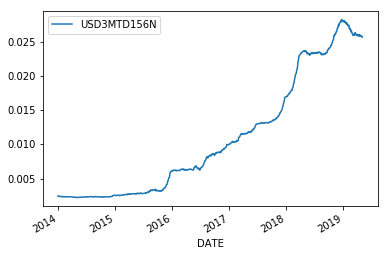

In [6]:
LIBOR.plot()

In [7]:
def minus_rf(daily_return):
    
    LIBOR_daily = LIBOR/360
    daily_return['LIBOR_3M'] = np.nan

    #先依據daily return裡面有的日期，將LIBOR_daily裡面也有的日期併進來，若沒有的先空著
    for i in range(len(daily_return)):
        if daily_return.index[i] in LIBOR.index:
            daily_return['LIBOR_3M'].iloc[i] = LIBOR_daily.loc[daily_return.index[i]].values
        else:
            pass

    #進一步將LIBOM_3M裡空著的格，以最靠近的數值取代，建立一個count來記錄最近的數值
    count = 0
    for i in range(len(daily_return)):
        if np.isnan(daily_return['LIBOR_3M'].iloc[i]):
            daily_return['LIBOR_3M'].iloc[i] = daily_return['LIBOR_3M'].iloc[count]
        else:
            count = i
            pass

    #將每一個日報酬率都減掉LIBOR_3M日報酬
    for i in range(len(daily_return)):
        for j in all_ticker:
            daily_return[j].iloc[i] -= daily_return['LIBOR_3M'].iloc[i]

    daily_return = daily_return.drop(columns = ['LIBOR_3M'])
    
    return daily_return

In [8]:
#若不需-rf則將此註解掉
daily_return = minus_rf(daily_return)

# 找出每個月最後一天，並計算出月報酬率

In [9]:
#挑出所有年月的最後一天
all_max_day_m = []
for i in range(daily_return.index.year.min(), daily_return.index.year.max()+1):
    for j in range(1, 13):
        mday = daily_return.loc[(daily_return.index.year == i) & (daily_return.index.month == j)].index.day.max()
        all_max_day_m.append(str(i) + '-' + ('0'+str(j) if j < 10 else str(j)) + '-' + str(mday))

all_max_day_m = [i for i in all_max_day_m if i[8:] != 'nan']

In [10]:
#建立monthly_return用來儲存月報酬
monthly_return = pd.DataFrame(index = all_max_day_m, columns = all_ticker)
monthly_return = monthly_return.set_index(pd.DatetimeIndex(monthly_return.index))

In [11]:
#換算成monthly return
for i in monthly_return.index:
    for j in all_ticker:
        d_return = daily_return[j][(daily_return.index.year == i.year) & (daily_return.index.month == i.month)]
        monthly_return[j][i] = (1 + d_return).cumprod()[-1] - 1

In [12]:
#只取近三年，並drop掉三年內有某個月沒有資料者
monthly_return = monthly_return.iloc[-1-36:-1]
monthly_return = monthly_return.dropna(axis='columns')

# 找出每週最後一天，並計算出周報酬率

In [13]:
all_max_day_w = []
weekday = daily_return.index[0].weekday()

#如果星期小於前一個的星期，代表換了一週，那就將前一個日期當作上一週的最後一天
for i in range(1, len(daily_return)):
    if daily_return.index[i].weekday() <= weekday:
        day = dt.strftime(daily_return.index[i - 1].date(), '%Y-%m-%d') 
        all_max_day_w.append(day)
        weekday = daily_return.index[i].weekday()
    else:
        weekday = daily_return.index[i].weekday()

In [14]:
weekly_return = pd.DataFrame(index = all_max_day_w, columns = all_ticker)
weekly_return = weekly_return.set_index(pd.DatetimeIndex(weekly_return.index))

In [15]:
#換算成weekly return
#如果週數一樣＆日期夾在上一週最後一天跟本週最一天之間，就是同一周的交易日
for i in range(1, len(weekly_return)):
    for j in all_ticker:
        d_return = daily_return[j][(daily_return.index.week == weekly_return.index[i].week) 
                                   & (daily_return.index <= weekly_return.index[i]) 
                                   & (daily_return.index >= weekly_return.index[i - 1])]
        weekly_return[j].iloc[i] = (1 + d_return).cumprod()[-1] - 1

In [16]:
#只取近三年，每年52週，並drop掉在156週裡有缺資料者
weekly_return = weekly_return[-1-52*3 : -1]
weekly_return = weekly_return.dropna(axis='columns')

In [17]:
#monthly_return.to_csv('/Users/Kang/Desktop/Monthly Return.csv')
#weekly_return.to_csv('/Users/Kang/Desktop/Weekly Return.csv')
#monthly_return.to_csv('/Users/Kang/Desktop/Monthly Return de_rf.csv')
#weekly_return.to_csv('/Users/Kang/Desktop/Weekly Return de_rf.csv')

In [18]:
monthly_return

,ADRD,ADRU,DAX,DBEU,DBEZ,DBGR,DBUK,DDEZ,DEZU,DFE,...,JPEU,NORW,OEUR,PGAL,RFEU,SCID,SMEZ,UPV,VGK,WBIA
2016-05-31,-0.00383847,-0.00585216,-0.0154423,0.017092,0.024795,0.0209951,0.00231134,-0.00263842,0.0022005,0.0174344,...,-0.0021326,-0.0261493,-0.0101208,-0.0188338,-0.00916147,0.00257295,-0.00532347,-0.00974678,-0.0053882,0.0283663
2016-06-30,-0.0172556,-0.0330273,-0.0527188,-0.0109273,-0.0543819,-0.0495419,0.0447305,0.00823031,-0.0732741,-0.100077,...,-0.0280527,-0.00890151,0.00410518,-0.0686891,-0.0385923,-0.0604594,-0.0893235,-0.110843,-0.0411314,-0.010399
2016-07-29,0.0354778,0.0410887,0.065219,0.0313723,0.0442007,0.0608142,0.0254231,-0.04831,0.0160103,0.0634727,...,0.0121822,-0.00515269,0.0112691,0.0665377,0.0491773,0.0385785,0.0612228,0.0740529,0.0343185,0.0428466
2016-08-31,0.000471025,-0.00404654,0.0224025,0.010925,0.0133017,0.0248188,0.0178174,0.0389961,0.0643419,0.00482086,...,0.0126011,0.00426884,-0.00560004,0.00346393,-0.00477554,0.0101468,0.0103768,0.019274,0.00631368,-0.0131313
2016-09-30,0.00346184,-0.00619588,0.000304251,0.00613628,0.00351336,-0.00347826,0.0216971,0.0129793,-0.0286675,0.0178239,...,0.0140433,0.0614385,-0.00715911,-0.0193363,0.0184703,0.00652505,0.0219217,0.00973265,0.00738658,-0.0176338
2016-10-31,-0.0347049,-0.0328374,-0.0121068,0.000262655,0.0118666,0.00888865,-0.000102694,-0.0130535,0.0163308,-0.0359253,...,-0.0459882,-0.00769034,-0.0625313,-0.00455497,-0.0121724,-0.0357944,-0.0227754,-0.0584063,-0.0357917,-0.0522272
2016-11-30,-0.00360738,-0.0143151,-0.0381466,-0.00633769,-0.0076288,-0.00603254,-0.0185453,-0.0227043,-0.016221,-0.0228193,...,-0.0425668,-0.00595127,-0.0485714,-0.0644561,-0.0207202,-0.0333783,-0.046974,-0.0630836,-0.0239166,0.114865
2016-12-30,0.0364034,0.0422733,0.068527,0.0572799,0.0721981,0.0726449,0.0475155,0.0839375,0.071255,0.055079,...,0.0437308,0.0326395,0.0487616,0.0526184,0.0504197,0.0361583,0.058145,0.094379,0.0486172,0.00527899
2017-01-31,0.0204504,0.024404,0.0336746,0.00258193,0.000548706,0.0141048,0.00140153,0.00211597,0.00101003,0.039138,...,0.0141703,0.0564645,0.0158393,-0.0102317,0.0234769,0.0293294,0.0363123,0.0555374,0.0290346,0.00597567
2017-02-28,0.0161151,0.0197531,0.00445409,0.0237976,0.0203024,0.018993,0.0289611,0.00901527,0.00783413,0.00455279,...,0.0165979,-0.0219622,0.0155099,0.0254659,0.00839451,0.0109477,0.0058598,0.00631215,0.0053211,0.0216529


In [19]:
weekly_return

,ADRD,ADRU,DAX,DBEU,DBEZ,DBGR,DBUK,DDEZ,DEZU,DFE,...,JPEU,NORW,OEUR,PGAL,RFEU,SCID,SMEZ,UPV,VGK,WBIA
2016-05-06,-0.0282901,-0.0294684,-0.0216407,-0.0171638,-0.0176727,-0.0140486,-0.0224877,-0.0343074,-8.79747e-05,-0.0112661,...,-0.0207697,-0.0350763,-0.0249597,0.000883744,-0.0402075,-0.0165217,-0.0126669,-0.0555692,-0.0245548,0.00567169
2016-05-13,-0.00976038,-0.00624387,-0.0137507,-0.00372336,-0.00578239,-0.00185709,0.00312078,-8.71636e-05,-0.033842,-0.0131582,...,-0.00679164,-0.00676613,0.00293877,-0.0350362,-0.00148058,-0.0010726,-0.0203447,-0.0129619,-0.0111883,-0.0105547
2016-05-20,0.0168765,0.0112681,-0.00764513,0.0128867,0.0138216,0.00301366,-0.00511361,-8.89413e-05,0.00340867,0.0149448,...,-0.0018755,0.00471388,0.00173271,-8.89475e-05,0.00395733,-0.00982355,0.0107821,0.022192,0.0103052,0.00465468
2016-05-27,0.0297329,0.0264494,0.0320537,0.0311299,0.0370312,0.0361397,0.0274531,0.0329957,0.0338918,0.0290004,...,0.0341131,0.0199822,0.0250136,0.0149968,0.0337919,0.0306542,0.01762,0.049877,0.0280945,0.0283754
2016-06-03,-0.00891187,-0.00405372,-0.00376416,-0.013662,-0.0183628,-0.0171324,-0.00677773,-7.58131e-05,-7.58131e-05,0.01089,...,-0.00959448,0.0064842,-0.00429867,-0.00106692,-0.0094839,0.00790689,0.0135993,-0.00767029,0.00072453,0.00254066
2016-06-10,-0.0258446,-0.0265498,-0.0352183,-0.0272441,-0.0290229,-0.0282889,-0.0126859,-9.12994e-05,0.0074933,-0.0338176,...,0.0256325,-0.022436,-0.0234144,-0.0139793,-0.0307153,0.00741133,-0.0401537,-0.0613114,-0.0374809,0.00265575
2016-06-17,-0.00945678,-0.0140978,-0.00541919,-0.0114165,-0.0127427,-0.0112502,-0.0328899,-9.04037e-05,-0.0799674,-0.0313109,...,-0.0680394,-0.0258029,-0.0154802,-0.0202097,-0.0116873,-0.0716615,-0.0232269,-0.0318815,-0.00709795,-0.0112767
2016-06-24,-0.0183167,-0.0259444,-0.0344648,-0.0203076,-0.0350044,-0.018933,0.0303077,0.00854245,-0.0228145,-0.0627181,...,-0.0143037,-0.0333218,-0.0258193,-0.0668189,-0.0320606,-0.0161305,-0.0503402,-0.063795,-0.0510772,-0.0148649
2016-07-01,0.0396958,0.0519113,0.0269059,0.0581215,0.0387195,0.0265123,0.07852,-8.92121e-05,0.0431637,0.016391,...,0.040287,0.0666401,0.0654801,0.0406119,0.0477989,0.0193841,0.0219997,0.049967,0.0502669,0.0156116
2016-07-08,-0.0153791,-0.0175803,-0.0202768,-0.00740818,-0.0139719,-0.01303,-0.00874985,-0.0836665,-0.0241987,-0.029179,...,-0.0337352,-0.0199778,-0.018876,-0.0148719,-0.0172619,-0.0281485,-0.0466784,-0.0460318,-0.0227608,0.0160768
